In [116]:
!pip install pytorch-tabnet
!pip install optuna

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import svm
from google.colab import output

from pytorch_tabnet.tab_model import  TabNetRegressor
np.random.seed(777)
st0 = np.random.get_state()

output.clear()

In [230]:
if os.path.isdir('Stark_ML'):
    !rm -rf Stark_ML
    !git clone https://github.com/alezakuskin/Stark_ML
else:
    !git clone https://github.com/alezakuskin/Stark_ML

import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting

importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)

from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from  Stark_ML.utils.plotting import *

output.clear()

# Data preprocessing

In [20]:
data = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )
data['Term'] = term_to_number(data['Term'])
data['Term.1'] = term_to_number(data['Term.1'])

In [21]:
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

#Separating into data for width and shift prediction
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])


data_shift = data[np.isnan(data['d (A)']) == False]
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])

#Selecting items for predicting both parameters simultaneously
data_both = data[(np.isnan(data['w (A)']) == False) & (np.isnan(data['d (A)']) == False)]
data_shift = data_shift.sort_values(by=['Z number'])
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

Number of items with width: 897
Number of items with shift: 351
Number of items with both parameters: 299

Size of elements-exclusive test set: 34


## Data visual description

In [22]:
data_width.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,...,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,8.970000e+02,897.000000
mean,437.237659,14.851728,1.769231,1.612040,3.460424,0.858417,1.943144,2.469342,0.332219,0.749164,...,0.001115,0.002230,0.001115,0.001115,2.899666,1.544036,0.603122,1.827202,2.113072e+05,16462.332219
std,216.218894,15.978406,0.421560,0.737235,2.179154,0.905723,2.720643,3.995171,0.687093,1.679233,...,0.033389,0.047193,0.033389,0.033389,1.247752,1.312079,0.489523,1.432334,3.325359e+06,9439.627870
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2950.000000
25%,283.999000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.387426e+04,10970.000000
50%,471.315614,7.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.848342e+04,12500.000000
75%,541.520000,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.184278e+05,20800.000000
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,1.000000,7.000000,9.968131e+07,50000.000000


In [23]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


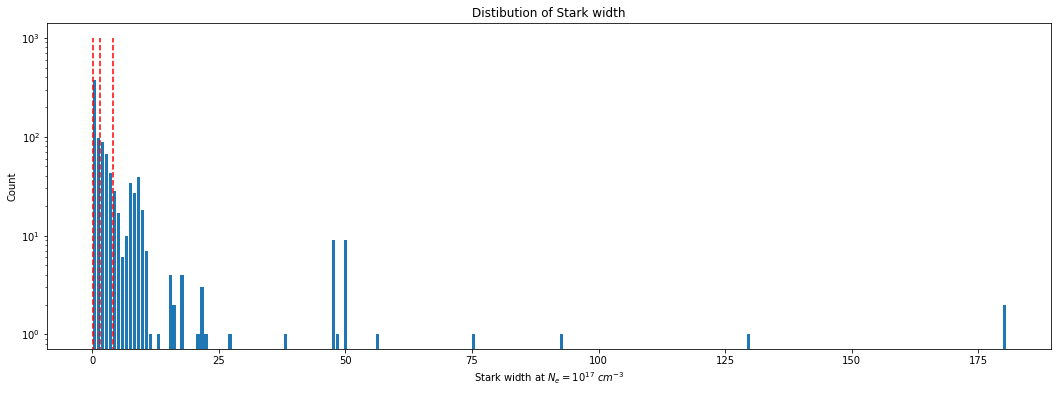

In [24]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

## Train - Test split

In [25]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

print(target_test_q4[target_test_q4 > 70])

581    130.0
585    180.5
580     75.5
Name: w (A), dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


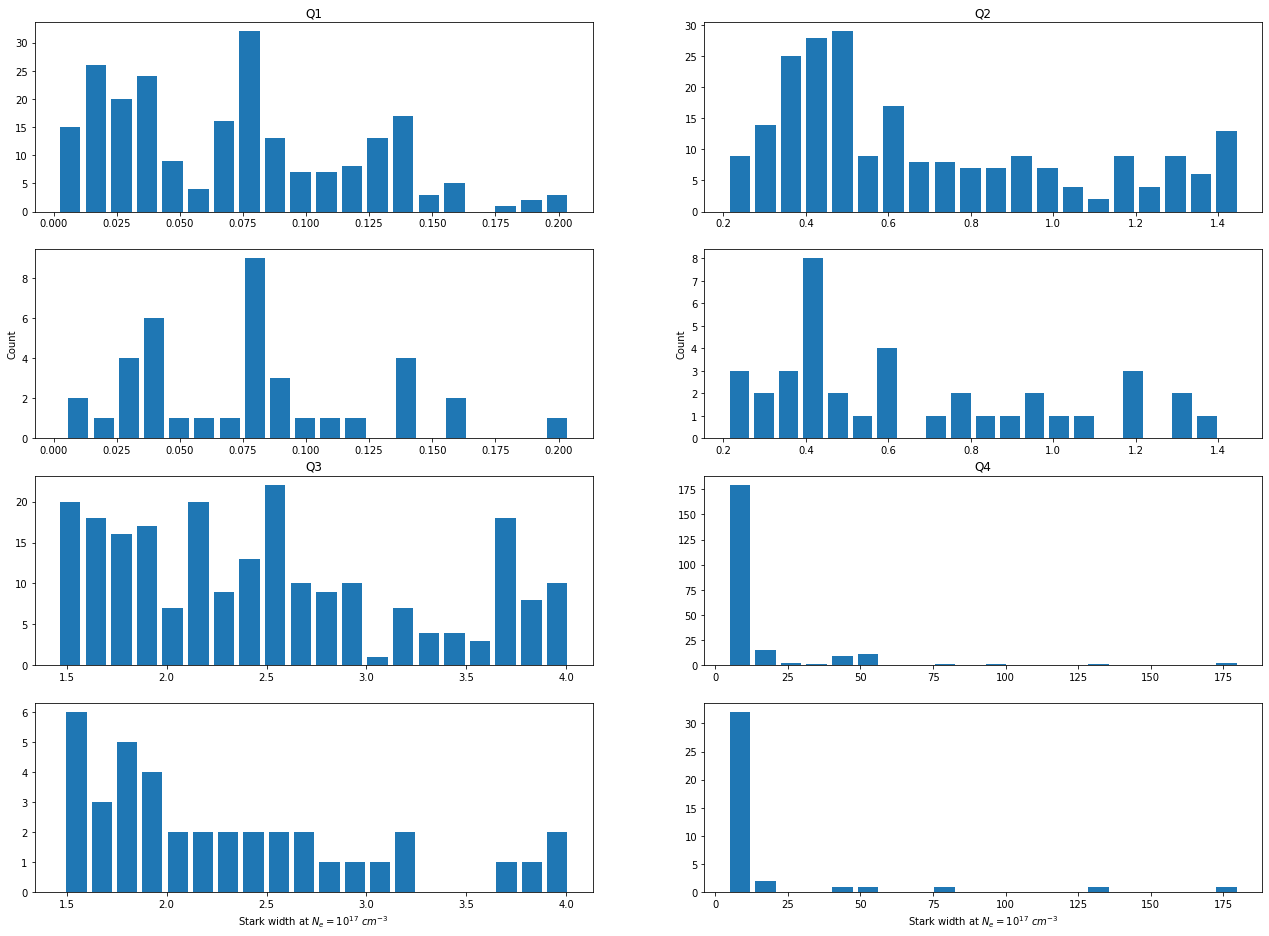

In [26]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [27]:
#Creating full train and test datasets
data_width_test, target_width_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_width_test, target_width_test = data_width_test.append(data_test_q3), target_width_test.append(target_test_q3)
data_width_test, target_width_test = data_width_test.append(data_test_q4), target_width_test.append(target_test_q4)

data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

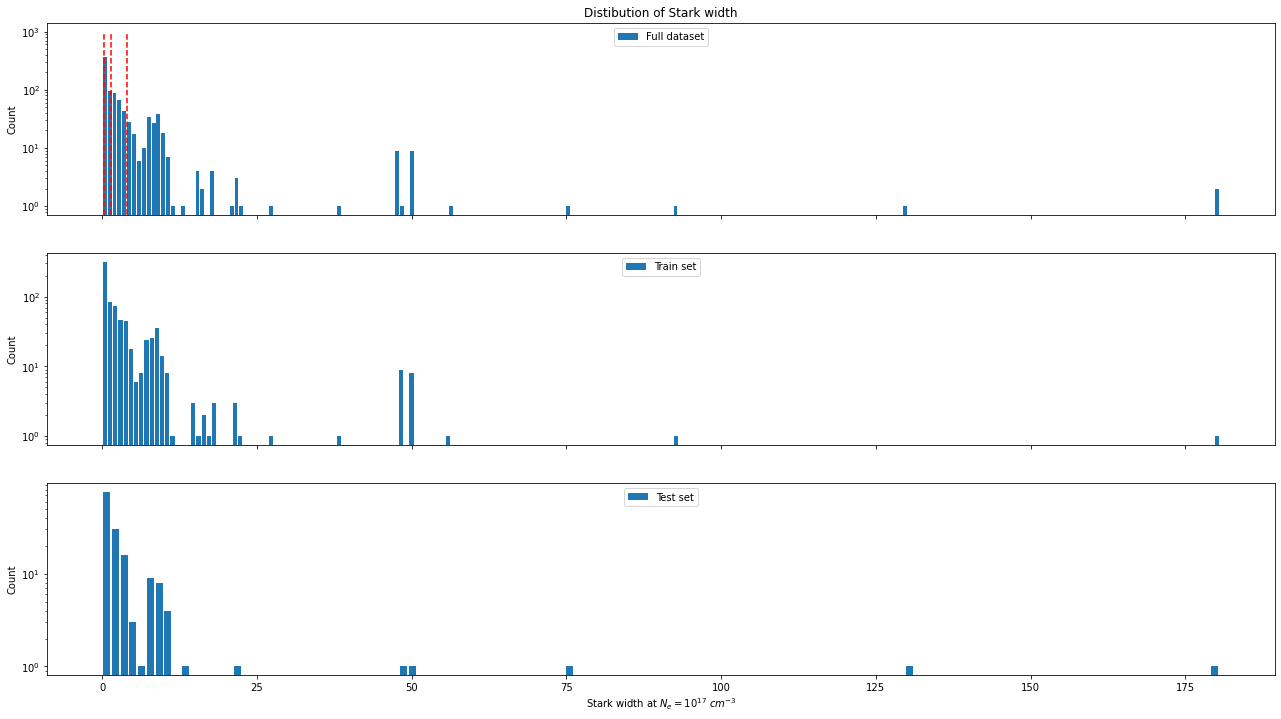

In [28]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

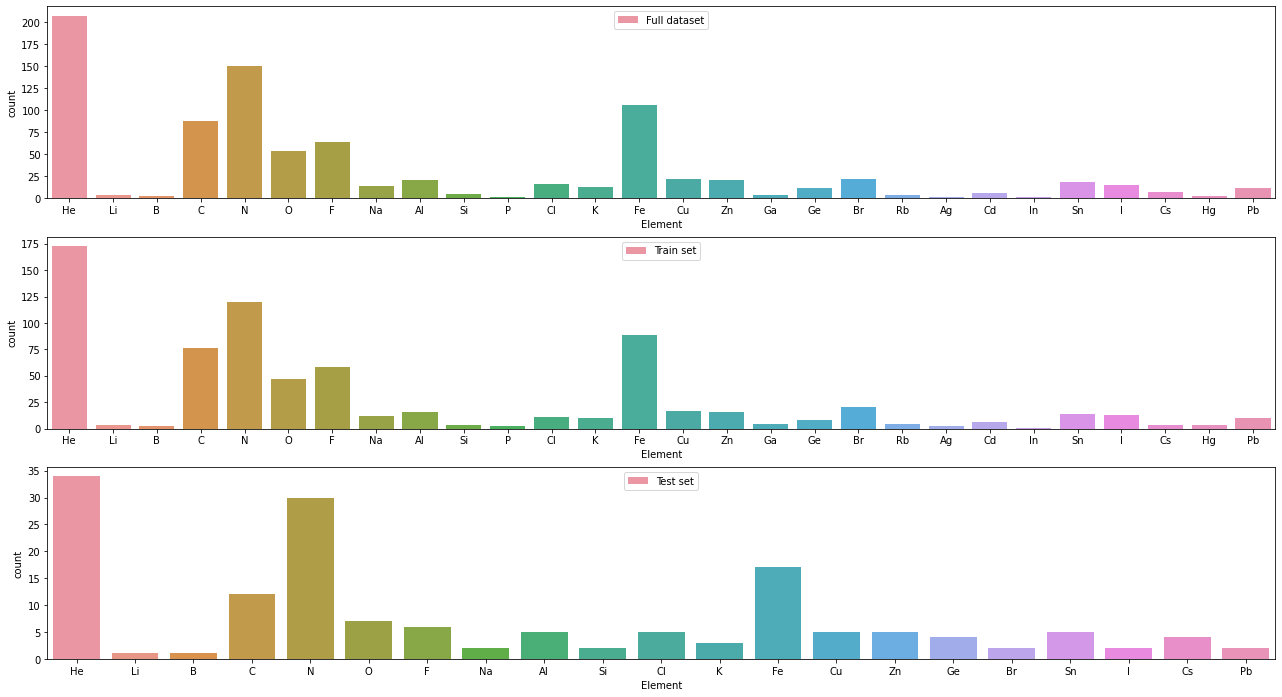

In [29]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [30]:
#Assigning proper variables
XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test


#XS_train, XS_test, YS_train, YS_test = train_test_split(data_shift, target_shift, test_size = 0.2, random_state = 7)
#XB_train, XB_test, YB_train, YB_test = train_test_split(data_both, target_both, test_size = 0.2, random_state = 7)

#Models optimization

## KNN

In [231]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : 'distance',
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 10,
    'squared_metrics' : True
    }

model_name = KNN

np.random.seed(7)
KNN_res = main(X = XW_train, y = YW_train, model_name = model_name, params = KNN_params, n_trials = 100)

[I 2022-04-11 19:24:20,376] A new study created in memory with name: no-name-24a92753-871a-4275-a09c-b5ec80664153


Start hyperparameter optimization


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-04-11 19:24:21,882] Trial 1 finished with value: 42.53163960453082 and parameters: {'n_neighbors': 71, 'leaf_size': 27, 'p': 1.741588898146351}. Best is trial 1 with value: 42.53163960453082.
[I 2022-04-11 19:24:21,952] Trial 0 finished with value: 43.641575649976836 and parameters: {'n_neighbors': 108, 'leaf_size': 72, 'p': 1.3792267008903059}. Best is trial 1 with value: 42.53163960453082.
[I 2022-04-11 19:24:23,065] Trial 2 finished with value: 57.580829058820235 and parameters: {'n_neighbors': 136, 'leaf_size': 80, 'p': 1.4476882538361533}. Best is trial 1 with value: 42.53163960453082.
[I 2022-04-11 19:24:23

Best parameters: {'n_neighbors': 2, 'leaf_size': 43, 'p': 1.2584961265004266}


Fitting old
Fitting new
Fitting default
Calculating bootstrap score for old
Calculating bootstrap score for new
Calculating bootstrap score for default


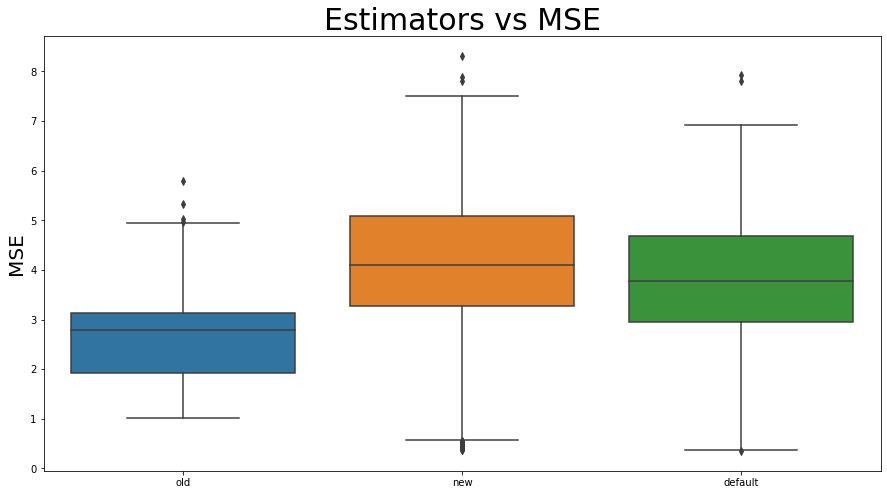

In [232]:
KNN_params = KNN_res.best_params

models = {}
models['old'] = KNeighborsRegressor(weights='distance',
                                          n_neighbors = 70,
                                          n_jobs = -1)
models['new'] = KNeighborsRegressor(**KNN_params, weights = 'distance')

models['default'] = KNeighborsRegressor(weights = 'distance')

results = train_and_test_regressor(models, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(results)

In [215]:
optuna.visualization.plot_contour(KNN_res)

## Random Forest

In [58]:
RF_params = {
    'n_estimators' : [10, 1000],
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'nfold' : 5
    }
#model_name = RandomForest
#main(X = XW_train, y = YW_train, model_name = model_name, params = params, n_trials = 200)

10.896320547034469
1.7544492044331288
245.0102358038138
309.0224285862797
28.65465796897463
{'algorithm': 'kd_tree', 'leaf_size': 88, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 98, 'p': 1.00112252380585, 'weights': 'distance'}

 119.06761842210715
Fitting old
Fitting new
Fitting default
Calculating bootstrap score for old
Calculating bootstrap score for new
Calculating bootstrap score for default


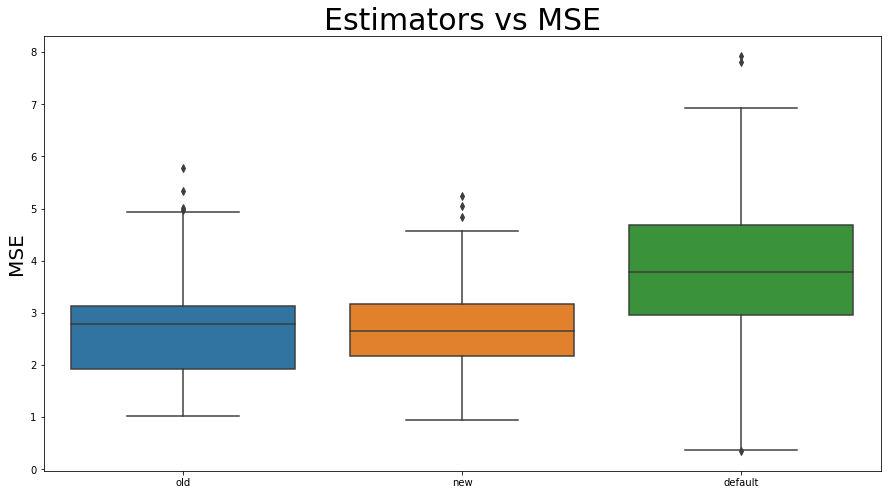

In [221]:
score = 0
kf = KFold(5, shuffle = False)
for train, test in kf.split(XW_train):
    model = KNeighborsRegressor(**KNN_params, weights = 'distance')
    model.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    score += mean_squared_error(YW_train.iloc[test], model.predict(XW_train.iloc[test, :]),
                                squared = True)
    print(mean_squared_error(YW_train.iloc[test], model.predict(XW_train.iloc[test, :]),
                                squared = True))

print(model.get_params())
score /= 5

print(f"\n {score}")

results = train_and_test_regressor(models, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(results)